* [The original ARTICLE](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/).
* [Newer article on the same topic](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/).


**[GAG notes]**
This is a good article and it explains quite well the thought behind hiearchical models. I read the first article, but the rest of the notebook here below is taken from the updated article.
I updated the code and fixed all issues.

There are also a link to a lot of good articles:
* [The Inference Button: Bayesian GLMs made easy with PyMC3](https://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)
* [This world is far from Normal(ly distributed): Bayesian Robust Regression in PyMC3](https://twiecki.github.io/blog/2013/08/27/bayesian-glms-2/)
* [Chris Fonnesbeck repo containing a more extensive analysis](https://github.com/fonnesbeck/multilevel_modeling/)
* [Shrinkage in multi-level hierarchical models](http://doingbayesiandataanalysis.blogspot.com/2012/11/shrinkage-in-multi-level-hierarchical.html)

Hierarchical models are underappreciated. Hierarchies exist in many data sets and modeling them appropriately adds a boat load of statistical power (the common metric of statistical power). I provided an introduction to hierarchical models in a previous blog post: [Best Of Both Worlds: Hierarchical Linear Regression in PyMC”, written with Danne Elbers](https://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/). See also my [interview with FastForwardLabs](http://blog.fastforwardlabs.com/2017/01/11/thomas-wiecki-on-probabilistic-programming-with.html) where I touch on these points.

## Dataset

Radon dataset: the amount of radioactive gas radon has been measured among different households in all county's states. 

The concentration of radon is thought to differ regionally due to different types of soil.

Here we will investigate this difference and try to make predictions of radon levels in different countys and where i the house radon was measured.
Here, In this example we’ll look at Minnesota, a state that contains 85 county’s in which different measurements are taken, ranging from 2 till 80 measurements per county.

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd
import theano
import seaborn as sns

data_url = 'https://raw.githubusercontent.com/pymc-devs/pymc4/master/notebooks/data/radon.csv'
data = pd.read_csv(data_url)

data['log_radon'] = data['log_radon'].astype(theano.config.floatX)

county_names = data.county.unique()
county_idx = data['county_code'].values

n_counties = len(data.county.unique())

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
data[['county', 'log_radon', 'floor', 'county_code']]

,county,log_radon,floor,county_code
0,AITKIN,0.832909,1.0,0
1,AITKIN,0.832909,0.0,0
2,AITKIN,1.098612,0.0,0
3,AITKIN,0.095310,0.0,0
4,ANOKA,1.163151,0.0,1
...,...,...,...,...
914,WRIGHT,1.871802,0.0,83
915,WRIGHT,1.526056,0.0,83
916,WRIGHT,1.629241,0.0,83
917,YELLOW MEDICINE,1.335001,0.0,84


In [8]:
data[['county', 'log_radon', 'floor']].dtypes

county        object
log_radon    float64
floor        float64
dtype: object

In [14]:
data.floor.values

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [15]:
county_idx

array([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       14, 14, 14, 14, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       19, 19, 19, 20, 20

In [16]:
n_counties

85

## The intuitive specification

Usually, hierachical models are specified in a centered way. In a regression model, individual slopes would be centered around a group mean with a certain group variance, which controls the shrinkage:

In [4]:
with pm.Model() as hierarchical_model_centered:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2) # hyper prior for the intercept
    sigma_a = pm.HalfCauchy('sigma_a', 5)

    mu_b = pm.Normal('mu_b', mu=0., sd=100**2) # hyper prio for the slope
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)

    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    # Linear regression
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)


In [5]:
# Inference button (TM)!
with hierarchical_model_centered:
    hierarchical_centered_trace = pm.sample(draws=5000, tune=1000)[1000:]

/home/gretar/Git/LEARNING/Bayesian_Statistics/coursera__introduction_to_pymc/env/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 12 seconds.
There were 645 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5867437015527057, but should be close to 0.8. Try to increase the number of tuning steps.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


I have seen plenty of traces with terrible convergences but this one might look fine to the unassuming eye. Perhaps sigma_b has some problems, so let’s look at the Rhat:

In [12]:
print('Rhat(sigma_b) = {}'.format(pm.diagnostics.gelman_rubin(hierarchical_centered_trace)['sigma_b']))

AttributeError: module 'pymc3' has no attribute 'diagnostics'

Not too bad – well below 1.01. I used to think this wasn’t a big deal but Michael Betancourt in his [StanCon 2017](https://www.youtube.com/watch?v=DJ0c7Bm5Djk&feature=youtu.be&t=4h40m9s) talk makes a strong point that it is actually very problematic. To understand what’s going on, let’s take a closer look at the slopes `b` and their group variance (i.e. how far they are allowed to move from the mean) `sigma_b`. I’m just plotting a single chain now.

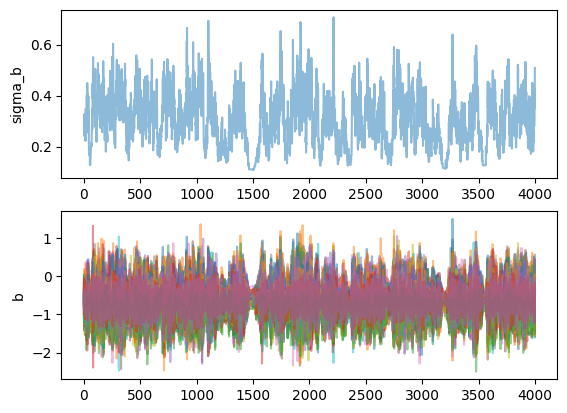

In [14]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(hierarchical_centered_trace.get_values('sigma_b', chains=1), alpha=.5);
axs[0].set(ylabel='sigma_b');
axs[1].plot(hierarchical_centered_trace.get_values('b', chains=1), alpha=.5);
axs[1].set(ylabel='b');

`sigma_b` seems to drift into this area of very small values and get stuck there for a while. This is a common pattern and the sampler is trying to tell you that there is a region in space that it can’t quite explore efficiently. While stuck down there, the slopes `b_i` become all squished together. We’ve entered **The Funnel of Hell** (it’s just called the funnel, I added the last part for dramatic effect).

## The Funnel of Hell (and how to escape it)

Let’s look at the joint posterior of a single slope `b` (I randomly chose the 75th one) and the slope group variance `sigma_b`.

**[GaG notes]** When he is saying the 75th one he is referring to the 75 county.

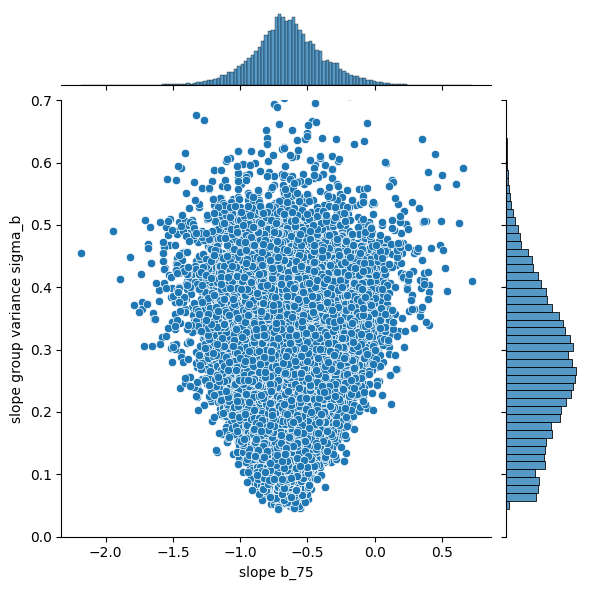

In [26]:
import pandas as pd
import seaborn as sns

# Assuming hierarchical_centered_trace['b'][:, 75] and hierarchical_centered_trace['sigma_b'] are available arrays
x = pd.Series(hierarchical_centered_trace['b'][:, 75], name='slope b_75')
y = pd.Series(hierarchical_centered_trace['sigma_b'], name='slope group variance sigma_b')

# Combine into a DataFrame
data = pd.DataFrame({'slope b_75': x, 'slope group variance sigma_b': y})

# Now use seaborn's jointplot with column names
sns.jointplot(data=data, x='slope b_75', y='slope group variance sigma_b', ylim=(0, .7))

This makes sense, as the slope group variance goes to zero (or, said differently, we apply maximum shrinkage), individual slopes are not allowed to deviate from the slope group mean, so they all collapose to the group mean.

While this property of the posterior in itself is not problematic, it makes the job extremely difficult for our sampler. Imagine a Metropolis-Hastings exploring this space with a medium step-size (we’re using NUTS here but the intuition works the same): in the wider top region we can comfortably make larger jumps to explore the space efficiently. However, once we move to the narrow bottom region we can change b_75 and sigma_b only by tiny amounts. This causes the sampler to become trapped in that region of space. Most of the proposals will be rejected because our step-size is too large for this narrow part of the space and exploration will be very inefficient.

You might wonder if we could somehow choose the step-size based on the denseness (or curvature) of the space. Indeed that’s possible and it’s called Riemannian HMC. It works very well but is quite costly to run. Here, we will explore a different, simpler method.

Finally, note that this problem does not exist for the intercept parameters a. Because we can determine individual intercepts a_i with enough confidence, sigma_a is not small enough to be problematic. Thus, the funnel of hell can be a problem in hierarchical models, but it does not have to be. (Thanks to John Hall for pointing this out).


**[GAG notes]:**

To summerize, the hyperprio that controls the with of the normal distribution becomes really small, that creates a huge constrains on what values the slopes can take. This will have a negative effect on the sampler which cannot sample efficiently.

## Reparameterization

If we can’t easily make the sampler step-size adjust to the region of space, maybe we can adjust the region of space to make it simpler for the sampler? This is indeed possible and quite simple with a small reparameterization trick, we will call this the non-centered version.

In [9]:
with pm.Model() as hierarchical_model_non_centered:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    # Before:
    # a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Transformed:
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)

    # Before:
    # b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)
    # Now:
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=n_counties)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)

    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

Pay attention to the definitions of `a_offset`, `a, b_offset`, and `b` and compare them to before (commented out). What’s going on here? It’s pretty neat actually. Instead of saying that our individual slopes b are normally distributed around a group mean (i.e. modeling their absolute values directly), we can say that they are offset from a group mean by a certain value (`b_offset`; i.e. modeling their values relative to that mean). Now we still have to consider how far from that mean we actually allow things to deviate (i.e. how much shrinkage we apply). This is where `sigma_b` makes a comeback. We can simply multiply the offset by this scaling factor to get the same effect as before, just under a different parameterization. For a more formal introduction, see e.g. (Betancourt & Girolami [2013](https://arxiv.org/pdf/1312.0906.pdf)

Critically, `b_offset` and `sigma_b` are now mostly independent. This will become more clear soon. Let’s first look at if this transform helped our sampling:

In [10]:
# Inference button (TM)
with hierarchical_model_non_centered:
    hierarchical_non_centered_trace = pm.sample(draws=5000, tune=1000)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b_offset, a_offset, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 11 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 190 divergences after tuning. Increase `target_accept` or reparameterize.
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/tmp/ipykernel_1578536/2381657741.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(hierarchical_non_centered_trace, var_names=['sigma_b']);
Got error No model on context stack. trying to find log_likelihood in translation.


/home/gretar/Git/LEARNING/Bayesian_Statistics/coursera__introduction_to_pymc/env/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


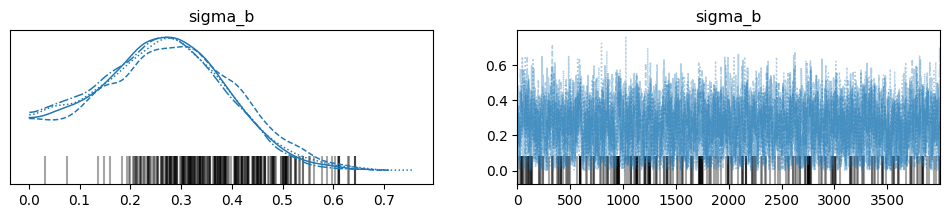

In [13]:
pm.traceplot(hierarchical_non_centered_trace, var_names=['sigma_b']);

That looks much better as also confirmed by the joint plot:

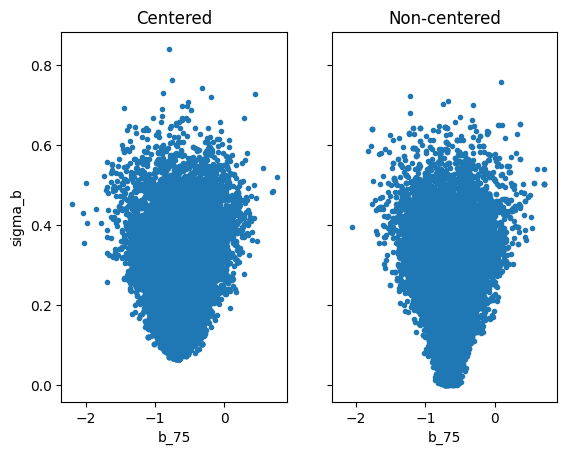

In [14]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

x = pd.Series(hierarchical_centered_trace['b'][:, 75], name='slope b_75')
y = pd.Series(hierarchical_centered_trace['sigma_b'], name='slope group variance sigma_b')

axs[0].plot(x, y, '.');
axs[0].set(title='Centered', ylabel='sigma_b', xlabel='b_75')

x = pd.Series(hierarchical_non_centered_trace['b'][:, 75], name='slope b_75')
y = pd.Series(hierarchical_non_centered_trace['sigma_b'], name='slope group variance sigma_b')

axs[1].plot(x, y, '.');
axs[1].set(title='Non-centered', xlabel='b_75');

To really drive this home, let’s also compare the `sigma_b` marginal posteriors of the two models:

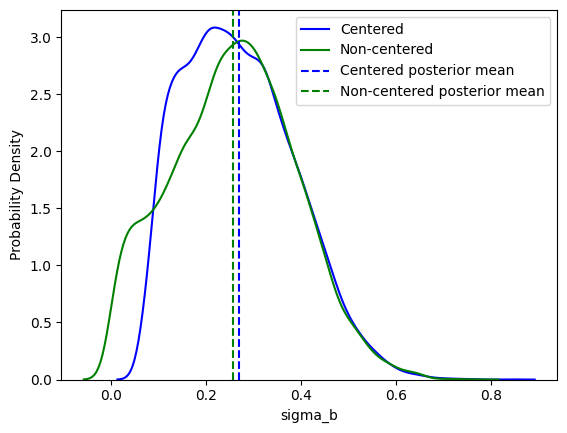

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming hierarchical_centered_trace and hierarchical_non_centered_trace are your trace dictionaries
# Stack the 'sigma_b' values from both traces for plotting
sigma_b_centered = hierarchical_centered_trace['sigma_b']
sigma_b_non_centered = hierarchical_non_centered_trace['sigma_b']

# Use seaborn's kdeplot for both centered and non-centered traces
sns.kdeplot(sigma_b_centered, color='b', linestyle='-', label='Centered')
sns.kdeplot(sigma_b_non_centered, color='g', linestyle='-', label='Non-centered')

# Add vertical lines for the means of each trace's 'sigma_b' values
plt.axvline(sigma_b_centered.mean(), color='b', linestyle='--', label='Centered posterior mean')
plt.axvline(sigma_b_non_centered.mean(), color='g', linestyle='--', label='Non-centered posterior mean')

# Adjust legend, labels, and show plot
plt.legend()
plt.xlabel('sigma_b')
plt.ylabel('Probability Density')
plt.show()

That’s crazy – there’s a large region of very small `sigma_b` values that the sampler could not even explore before. In other words, our previous inferences (“Centered”) were severely biased towards higher values of `sigma_b`. Indeed, if you look at the previous blog post the sampler never even got stuck in that low region causing me to believe everything was fine. These issues are hard to detect and very subtle, but they are meaningful as demonstrated by the sizable difference in posterior mean.

But what does this concretely mean for our analysis? Over-estimating sigma_b means that we have a biased (=false) belief that we can tell individual slopes apart better than we actually can. There is less information in the individual slopes than what we estimated.

## Why does the reparameterized model work better?

To more clearly understand why this model works better, let’s look at the joint distribution of `b_offset`:

In [20]:
x = pd.Series(hierarchical_non_centered_trace['b_offset'][:, 75], name='slope b_offset_75')
y = pd.Series(hierarchical_non_centered_trace['sigma_b'], name='slope group variance sigma_b')

sns.jointplot(x, y, ylim=(0, .7))

TypeError: jointplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

This is the space the sampler sees; you can see how the funnel is flattened out. We can freely change the (relative) slope offset parameters even if the slope group variance is tiny as it just acts as a scaling parameter.

Note that the funnel is still there – it’s a perfectly valid property of the model – but the sampler has a much easier time exploring it in this different parameterization.

## Why hierarchical models are Bayesian

**[This is a good point]**
Finally, I want to take the opportunity to make another point that is not directly related to hierarchical models but can be demonstrated quite well here.

Usually when talking about the perils of Bayesian statistics we talk about priors, uncertainty, and flexibility when coding models using Probabilistic Programming. However, an even more important property is rarely mentioned because it is much harder to communicate. Ross Taylor touched on this point in his tweet:

``` 
It's interesting that many summarize Bayes as being about priors; but real power is its focus on integrals/expectations over maxima/modes
```

Michael Betancourt makes a similar point when he says [“Expectations are the only thing that make sense.”](https://www.youtube.com/watch?v=pHsuIaPbNbY&t=8s)

But what’s wrong with maxima/modes? Aren’t those really close to the posterior mean (i.e. the expectation)? Unfortunately, that’s only the case for the simple models we teach to build up intuitions. In complex models, like the hierarchical one, the MAP can be far away and not be interesting or meaningful at all.

Let’s compare the posterior mode (i.e. the MAP) to the posterior mean of our hierachical linear regression model:

In [21]:
with hierarchical_model_centered:
    mode = pm.find_MAP()

In [22]:
mode['b']

array([-2380137.14618281,   781193.10369623, -1647557.99345632,
        3538729.09769019, -2643786.22988378, -2084120.99198377,
       -2215763.05419575, -1818362.78135302, -3316937.78255536,
         561356.1286674 , -2084120.99198377, -2084120.99198377,
       -2084120.99198377,  5431953.78263249, -1487052.34761703,
       -2084120.99198377,   226793.59676119,   836249.7387454 ,
        1867700.35194883, -2084120.99198377, -2697549.76697622,
       -1749285.81028141, -2548707.44525704, -1439734.42040065,
       -2130621.74782847, -3554149.44355295, -1721488.42695084,
         347362.8581169 , -2084120.99198377, -2084120.99198377,
       -2084120.99198377, -2084120.99198377, -2084120.99198377,
       -1481771.16008907,  2475315.21525407, -4259224.55994226,
       -1756117.69271775, -1969390.93592717, -3004673.65116204,
       -2775400.76948483, -3431711.70408646, -2084120.99198377,
        4164182.01717824,  -646583.98350585,  3019251.54214371,
       -2084120.99198377,  -794925.29830

As you can see, the slopes are all identical and the group slope variance is effectively zero. The reason is again related to the funnel. The MAP only cares about the probability density which is highest at the bottom of the funnel.

But if you could only choose one point in parameter space to summarize the posterior above, would this be the one you’d pick? Probably not.

Let’s instead look at the Expected Value (i.e. posterior mean) which is computed by integrating probability density and volume to provide probabilty mass – the thing we really care about. Under the hood, that’s the integration performed by the MCMC sampler.

In [28]:
hierarchical_non_centered_trace['b'].mean(axis=0)

array([-0.6150279 , -0.78167511, -0.63584736, -0.68385785, -0.61392245,
       -0.65065445, -0.42734375, -0.62269027, -0.4950771 , -0.71704978,
       -0.65338244, -0.64334238, -0.64585697, -0.70991028, -0.6503266 ,
       -0.64509417, -0.76590243, -0.53508473, -0.73358085, -0.63775466,
       -0.60339792, -0.66481066, -0.63019936, -0.64101066, -0.43890994,
       -0.7258147 , -0.60824218, -0.63540844, -0.65245179, -0.64750191,
       -0.6491756 , -0.64453264, -0.64586663, -0.67512121, -0.60735045,
       -0.49530216, -0.63774161, -0.58400359, -0.58338164, -0.64140088,
       -0.54718357, -0.64916044, -0.97138352, -0.79715991, -0.76471656,
       -0.65204845, -0.81149958, -0.58284202, -0.81734436, -0.64944783,
       -0.64405782, -0.64494577, -0.68434841, -0.81919824, -0.57727902,
       -0.76704774, -0.67507089, -0.58305871, -0.71262365, -0.65284541,
       -0.43868139, -0.39259483, -0.53418286, -0.67498533, -0.65873592,
       -0.60176376, -0.42525519, -0.65160618, -0.64342823, -0.60

In [29]:
hierarchical_non_centered_trace['sigma_b'].mean(axis=0)

0.2581196116320019

Quite a difference. **This also explains why it can be a bad idea to use the MAP to initialize your sampler: in certain models the MAP is not at all close to the region you want to explore (i.e. the “typical set”).**

This strong divergence of the MAP and the Posterior Mean does not only happen in hierarchical models but also in high dimensional ones, where our intuitions from low-dimensional spaces gets twisted in serious ways. This talk by [Michael Betancourt](https://www.youtube.com/watch?v=pHsuIaPbNbY&t=8s) makes the point quite nicely.

So why do people – especially in Machine Learning – still use the MAP/MLE? As we all learned in high school first hand, integration is much harder than differentation. This is really the only reason.

Final disclaimer: This might provide the impression that this is a property of being in a Bayesian framework, which is not true. Technically, we can talk about Expectations vs Modes irrespective of that. Bayesian statistics just happens to provide a very intuitive and flexible framework for expressing and estimating these models.